In [1]:
import warnings                           
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# after introducing boolian features we need to scale them

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

from dateutil.relativedelta import relativedelta 
from scipy.optimize import minimize

import statsmodels.formula.api as smf 
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

In [2]:
data = pd.read_excel('./data/день - количество блюд.xlsx', skiprows= 3, usecols= [0,1], names = ['date', 'meals'])
data.head()

,date,meals
0,2018-04-06 00:00:00,32.0
1,2018-04-07 00:00:00,8.0
2,2018-04-08 00:00:00,4.0
3,2018-04-09 00:00:00,14.0
4,2018-04-10 00:00:00,5.0


In [3]:
# remove the last row
data = data.iloc[:-1]

In [4]:
data['date'] = pd.to_datetime(data['date'])
data = data.set_index('date')
data.head()

,meals
date,
2018-04-06,32.0
2018-04-07,8.0
2018-04-08,4.0
2018-04-09,14.0
2018-04-10,5.0


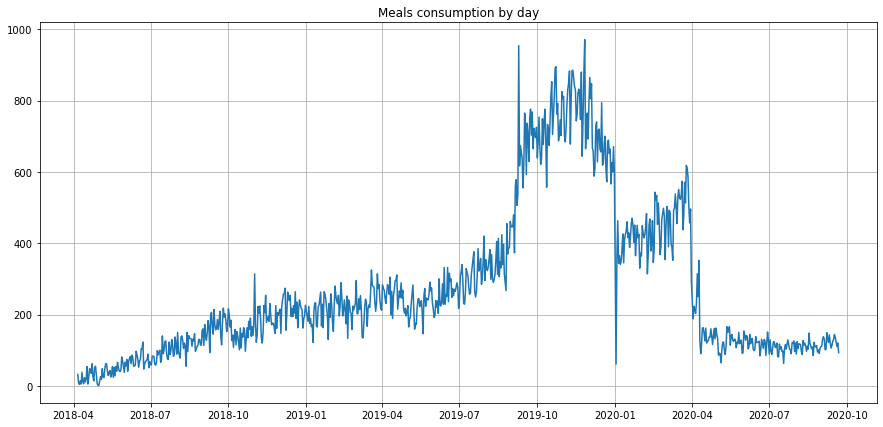

In [5]:
plt.figure(figsize=(15,7))
plt.plot(data)
plt.title('Meals consumption by day')
plt.grid(True)
plt.show()

In [6]:
time_data = pd.DataFrame(data.meals.copy())
time_data.columns = ["target"]

In [7]:
# Adding the lag of the target varable from 7 steps back (week) up to 30 (month)

for i in range(7, 31):
    time_data["lag_{}".format(i)] = time_data.target.shift(i)

In [8]:
time_data.tail(10)

,target,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
date,,,,,,,,,,,,,,,,,,,,,
2020-09-12,106.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0,101.0,...,85.0,109.0,104.0,113.0,119.0,148.0,103.0,111.0,97.0,113.0
2020-09-13,113.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0,...,122.0,85.0,109.0,104.0,113.0,119.0,148.0,103.0,111.0,97.0
2020-09-14,125.0,149.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0,...,110.0,122.0,85.0,109.0,104.0,113.0,119.0,148.0,103.0,111.0
2020-09-15,130.0,133.0,149.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0,...,109.0,110.0,122.0,85.0,109.0,104.0,113.0,119.0,148.0,103.0
2020-09-16,144.0,122.0,133.0,149.0,102.0,101.0,131.0,138.0,131.0,111.0,...,113.0,109.0,110.0,122.0,85.0,109.0,104.0,113.0,119.0,148.0
2020-09-17,136.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,138.0,131.0,...,95.0,113.0,109.0,110.0,122.0,85.0,109.0,104.0,113.0,119.0
2020-09-18,123.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,138.0,...,101.0,95.0,113.0,109.0,110.0,122.0,85.0,109.0,104.0,113.0
2020-09-19,110.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,...,91.0,101.0,95.0,113.0,109.0,110.0,122.0,85.0,109.0,104.0
2020-09-20,120.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,...,105.0,91.0,101.0,95.0,113.0,109.0,110.0,122.0,85.0,109.0


In [9]:
# we kinda have a dataset, so we could try modeling

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

tscv = TimeSeriesSplit(n_splits=5)

In [10]:
def timeseries_train_test_split(X, y, test_size):
    """
        Perform train-test split with respect to time series structure
    """
    
    test_index = int(len(X)*(1 - test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test

In [11]:
time_data.shape

(897, 25)

In [12]:
def train_test_split(X):
    
    target = X.dropna().target
    X = X.dropna().drop(['target'], axis=1)
    X_train, X_test, y_train, y_test = timeseries_train_test_split(X, target, test_size=0.3)
    
    return X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = train_test_split(time_data)

In [14]:
print(X_train.shape, X_test.shape)

(606, 24) (261, 24)


In [15]:
def linear_regression_model(X_train, y_train):
    
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    
    return lr

In [16]:
lr = linear_regression_model(X_train, y_train)

In [17]:
def plotModelResults(model, X_train, X_test, plot_intervals=False, plot_anomalies=False):
    """
        Plots modelled vs fact values, prediction intervals and anomalies
    
    """
    
    prediction = model.predict(X_test)
    
    plt.figure(figsize=(15, 7))
    plt.plot(prediction, "g", label="prediction", linewidth=2.0)
    plt.plot(y_test.values, label="actual", linewidth=2.0)
    
    if plot_intervals:
        cv = cross_val_score(model, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
        mae = cv.mean() * (-1)
        deviation = cv.std()
        
        scale = 1.96
        lower = prediction - (mae + scale * deviation)
        upper = prediction + (mae + scale * deviation)
        
        plt.plot(lower, "r--", label="upper bond / lower bond", alpha=0.5)
        plt.plot(upper, "r--", alpha=0.5)
        
        if plot_anomalies:
            anomalies = np.array([np.NaN]*len(y_test))
            anomalies[y_test<lower] = y_test[y_test<lower]
            anomalies[y_test>upper] = y_test[y_test>upper]
            plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    error = mean_absolute_percentage_error(prediction, y_test)
    plt.title("Mean absolute percentage error {0:.2f}%".format(error))
    plt.legend(loc="best")
    plt.tight_layout()
    plt.grid(True);
    
def plotCoefficients(model):
    """
        Plots sorted coefficient values of the model
    """
    
    coefs = pd.DataFrame(model.coef_, X_train.columns)
    coefs.columns = ["coef"]
    coefs["abs"] = coefs.coef.apply(np.abs)
    coefs = coefs.sort_values(by="abs", ascending=False).drop(["abs"], axis=1)
    
    plt.figure(figsize=(15, 7))
    coefs.coef.plot(kind='bar')
    plt.grid(True, axis='y')
    plt.hlines(y=0, xmin=0, xmax=len(coefs), linestyles='dashed');

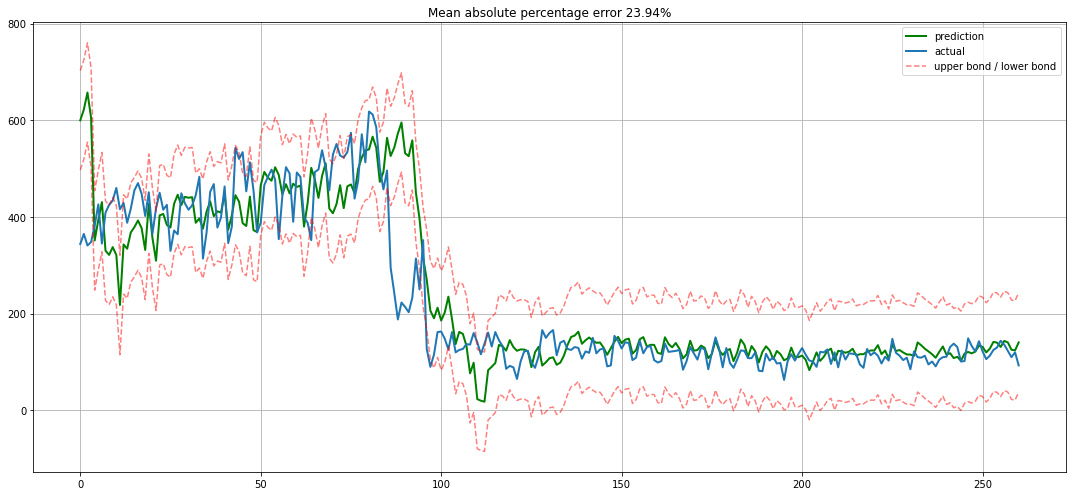

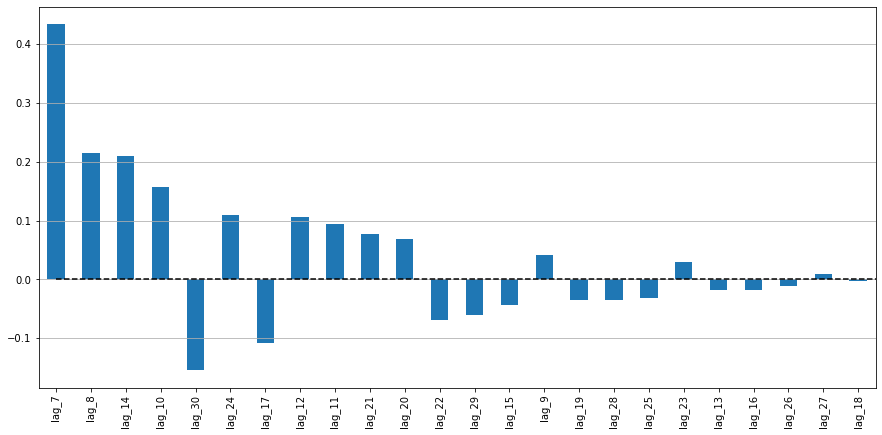

In [18]:
plotModelResults(lr, X_train, X_test, plot_intervals=True)
plotCoefficients(lr)

In [19]:
weekend_features = time_data.copy()

In [20]:
# adding a few more new features (weekend and weekday)

weekend_features['weekday'] = weekend_features.index.weekday
weekend_features['is_weekend'] = weekend_features.weekday.isin([5,6])*1
weekend_features.tail(15)

,target,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,weekday,is_weekend
date,,,,,,,,,,,,,,,,,,,,,
2020-09-07,149.0,110.0,105.0,91.0,101.0,95.0,113.0,109.0,110.0,122.0,...,111.0,97.0,113.0,120.0,114.0,127.0,88.0,95.0,0,0
2020-09-08,133.0,111.0,110.0,105.0,91.0,101.0,95.0,113.0,109.0,110.0,...,103.0,111.0,97.0,113.0,120.0,114.0,127.0,88.0,1,0
2020-09-09,122.0,131.0,111.0,110.0,105.0,91.0,101.0,95.0,113.0,109.0,...,148.0,103.0,111.0,97.0,113.0,120.0,114.0,127.0,2,0
2020-09-10,143.0,138.0,131.0,111.0,110.0,105.0,91.0,101.0,95.0,113.0,...,119.0,148.0,103.0,111.0,97.0,113.0,120.0,114.0,3,0
2020-09-11,122.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0,101.0,95.0,...,113.0,119.0,148.0,103.0,111.0,97.0,113.0,120.0,4,0
2020-09-12,106.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0,101.0,...,104.0,113.0,119.0,148.0,103.0,111.0,97.0,113.0,5,1
2020-09-13,113.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0,...,109.0,104.0,113.0,119.0,148.0,103.0,111.0,97.0,6,1
2020-09-14,125.0,149.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0,105.0,...,85.0,109.0,104.0,113.0,119.0,148.0,103.0,111.0,0,0
2020-09-15,130.0,133.0,149.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0,...,122.0,85.0,109.0,104.0,113.0,119.0,148.0,103.0,1,0


In [21]:
weekend_features.shape

(897, 27)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(weekend_features)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [23]:
X_train_scaled.shape

(606, 26)

In [24]:
lr = linear_regression_model(X_train_scaled, y_train)

In [25]:
print(X_train.shape, X_test.shape)
print(X_train_scaled.shape, X_test_scaled.shape)

(606, 26) (261, 26)
(606, 26) (261, 26)


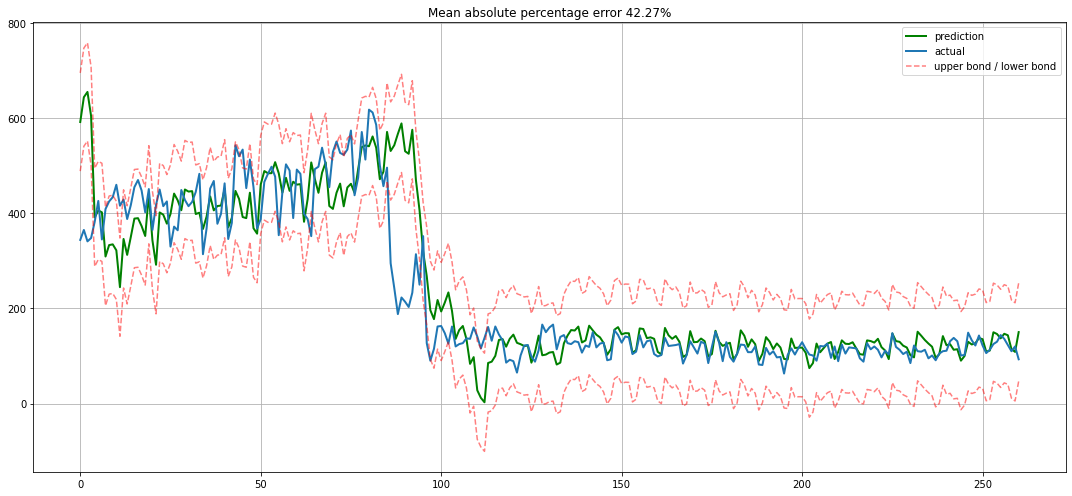

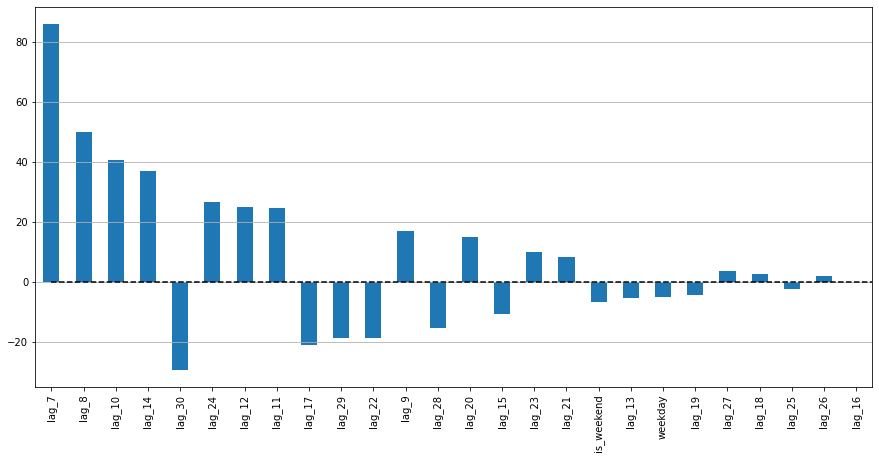

In [26]:
plotModelResults(lr, X_train_scaled, X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

Introducing $weekday$ and $weekend$ made the prediction worse. I do not really know the reason yet, so lets move forward for now. Transforming $weekday$ into one hot leads to an awful overfitting with these 7 newly created features (7 days of the week) having the most feature importance.

### Target Encoding

In [27]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

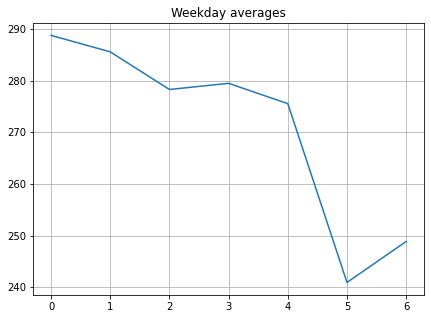

In [28]:
average_hour = code_mean(weekend_features, 'weekday', "target")
plt.figure(figsize=(7, 5))
plt.title("Weekday averages")
pd.DataFrame.from_dict(average_hour, orient='index')[0].plot()
plt.grid(True);

In [29]:
test_index = int(len(weekend_features)*(1 - 0.3))
weekend_features_target_enc = weekend_features.copy()

weekend_features_target_enc['weekday_average'] = list(map(code_mean(weekend_features_target_enc[:test_index], 'weekday', "target").get, 
                                               weekend_features_target_enc.weekday))
weekend_features_target_enc.drop(["weekday"], axis=1, inplace=True)

weekend_features_target_enc.tail()

,target,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,...,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,is_weekend,weekday_average
date,,,,,,,,,,,,,,,,,,,,,
2020-09-17,136.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,138.0,131.0,...,109.0,110.0,122.0,85.0,109.0,104.0,113.0,119.0,0,292.977528
2020-09-18,123.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,138.0,...,113.0,109.0,110.0,122.0,85.0,109.0,104.0,113.0,0,285.605556
2020-09-19,110.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,...,95.0,113.0,109.0,110.0,122.0,85.0,109.0,104.0,1,252.222222
2020-09-20,120.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,...,101.0,95.0,113.0,109.0,110.0,122.0,85.0,109.0,1,258.633333
2020-09-21,93.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,...,91.0,101.0,95.0,113.0,109.0,110.0,122.0,85.0,0,303.367733


In [30]:
X_train, X_test, y_train, y_test = train_test_split(weekend_features_target_enc)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [31]:
X_train_scaled.shape

(606, 26)

In [32]:
lr = linear_regression_model(X_train_scaled, y_train)

In [33]:
print(X_train.shape, X_test.shape)
print(X_train_scaled.shape, X_test_scaled.shape)

(606, 26) (261, 26)
(606, 26) (261, 26)


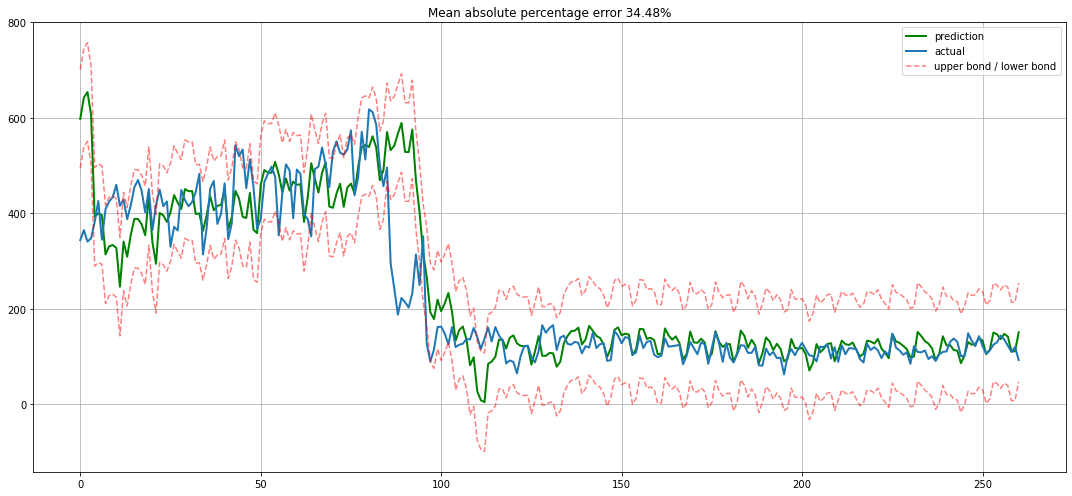

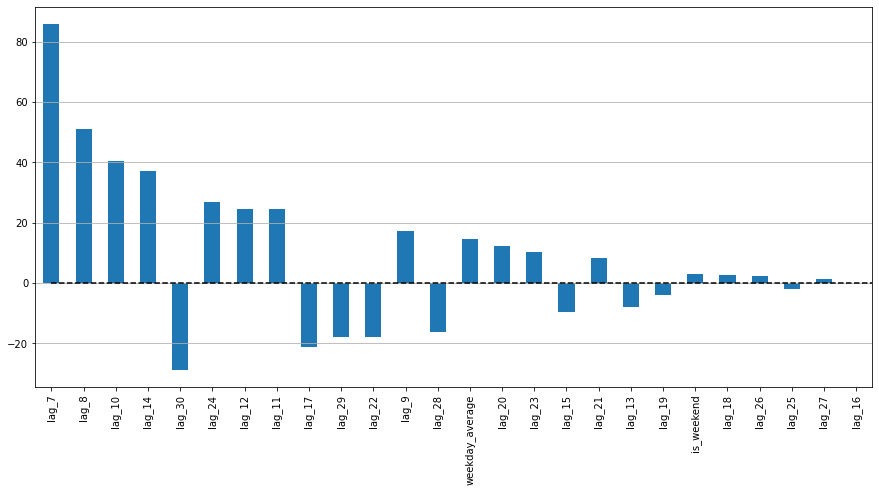

In [34]:
plotModelResults(lr, X_train_scaled, X_test_scaled, plot_intervals=True)
plotCoefficients(lr)

Mean encoding helped a lot. However the error is still way above if we would not even introduce that feature.

### Regularization and feature selection

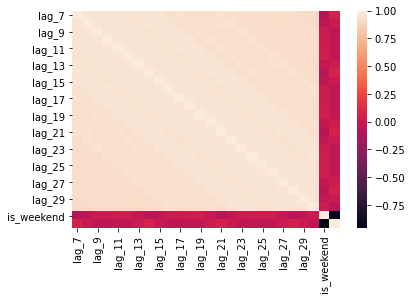

In [35]:
sns.heatmap(X_train.corr());

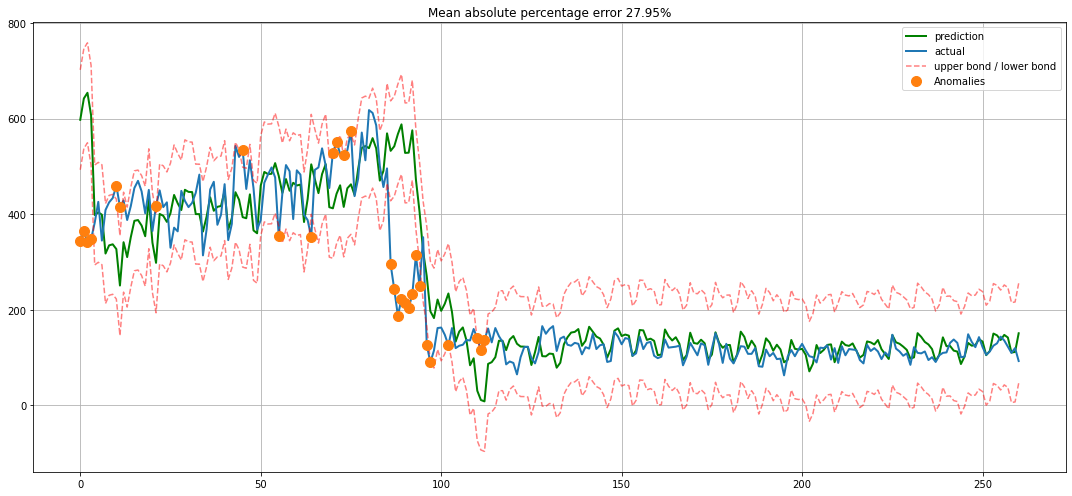

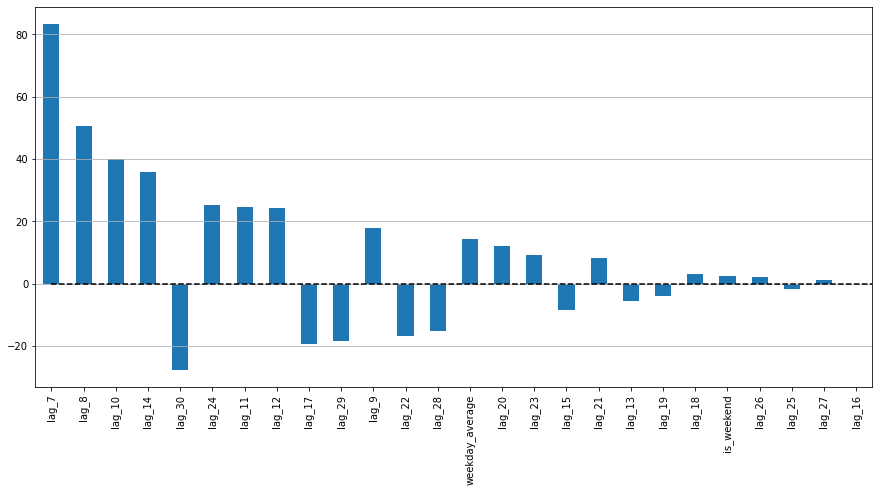

In [36]:
from sklearn.linear_model import LassoCV, RidgeCV

ridge = RidgeCV(cv=tscv)
ridge.fit(X_train_scaled, y_train)

plotModelResults(ridge, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(ridge)

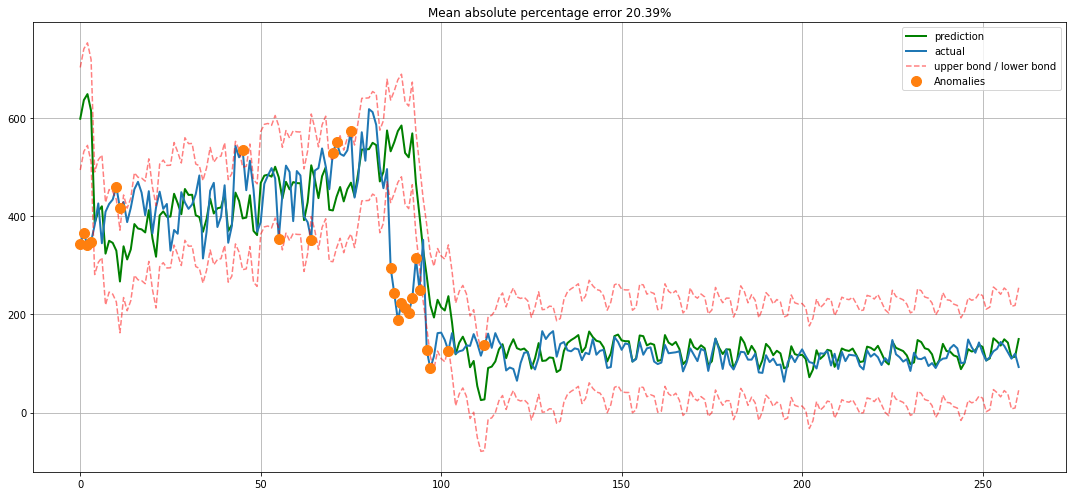

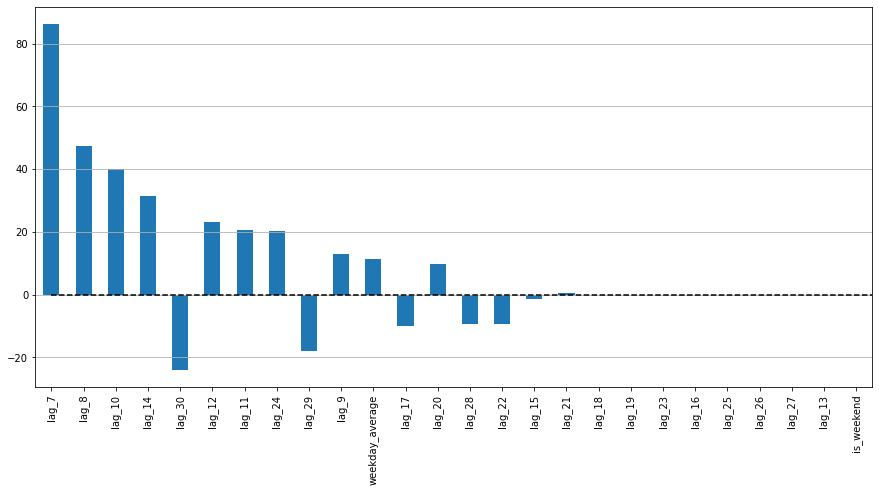

In [37]:
lasso = LassoCV(cv=tscv)
lasso.fit(X_train_scaled, y_train)

plotModelResults(lasso, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)
plotCoefficients(lasso)

Both Lasso and Ridge showed outstanding improvement of an error. Next step would be to try both of these models on the dataset without $weekday$

### Boosting

In [38]:
from xgboost import XGBRegressor 

xgb = XGBRegressor()
xgb.fit(X_train_scaled, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

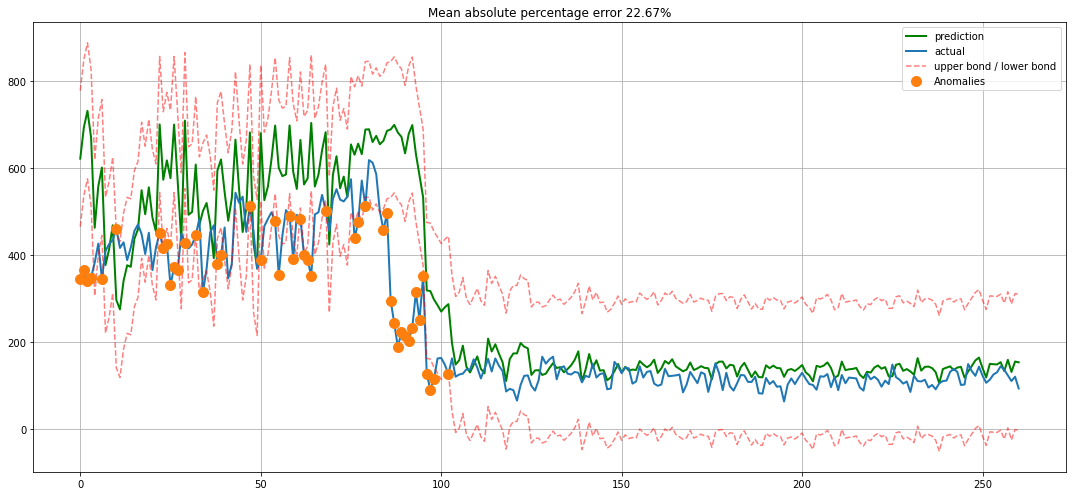

In [39]:
plotModelResults(xgb, 
                 X_train=X_train_scaled, 
                 X_test=X_test_scaled, 
                 plot_intervals=True, plot_anomalies=True)

The boosting algo showed worse result, than the linear models. Tt might not be the brightest idea to fit xgboost as soon as you get your hands on time series data. Generally, tree-based models handle trends in data poorly when compared with linear models. In that case, you would have to detrend your series first or use some tricks to make the magic happen. Ideally, you can make the series stationary and then use XGBoost. For example, you can forecast trend separately with a linear model and then add predictions from xgboost to get a final forecast. So basically the approach would be to do kind of stackin; get predictions from linear models and then apply gradient boosting.

ideas for features: 
    - public holiday in Bashkorstostan 